# Building our dataset

now that wa have donwloaded the samples from CoRe database we can start to build our *dataset* and *dataloader* using *PyTorch*. Lets explore a little more on the dataset we have in hands

In [ ]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from pathlib import Path

In [ ]:
from torch.utils.data import Dataset, DataLoader, random_split
import torch
from torchvision.utils import make_grid

In [ ]:
# for avoiding memory errors in paperspace
import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')

In [ ]:
DATA_PATH = Path('../datasets/')
OUT_PATH = Path('./outputs/')

In [ ]:
def pad_seq(seq, max_size = 1024):
    size = np.shape(seq)
    px = np.abs(max_size - size[0])
    seq = np.pad(seq, (np.int(np.floor(px/2.)), np.int(np.ceil(px/2.))), 'constant')
    return seq

In [ ]:
def interp_selct(timeseries, window=300, out_len=2048):
    timeseries /= timeseries.max()
    idx_max = timeseries.argmax()
    selected = timeseries[idx_max-window:]
    shape = selected.shape[-1]
    interp = np.interp(np.linspace(0,shape,num=out_len),np.arange(shape), selected)
    return interp

In [ ]:
class Data_GW(Dataset):
    def __init__(self,  transform=None):
        self.transform = transform
        f = h5py.File(DATA_PATH/'BSk20_redux.hdf5', 'r')
        self.samples = list(f['waves'])
            
    def __getitem__(self, idx):

        sample = {
            'waveform':self.samples[idx].reshape(-1)
        }
        if self.transform is not None:
            sample = self.transform(sample)
        
        return sample
    
    def __len__(self):
        return len(self.samples)

In [ ]:
def my_collate(batch):
    #function to transform the batches at once
    data = np.stack([interp_selct(item['waveform']).reshape(1,-1) for item in batch])
    data = torch.from_numpy(data).float()
    return {'waveform':data}

In [ ]:
dataset = Data_GW()

In [ ]:
len_data = len(dataset)
len_train = int(.8*len_data)
len_val = len_data - len_train

In [ ]:
train_ds, val_ds = random_split(dataset, [len_train, len_val])

In [ ]:
len(train_ds)

800

In [ ]:
dataset[8]['waveform'].shape

(2048,)

[<matplotlib.lines.Line2D>]

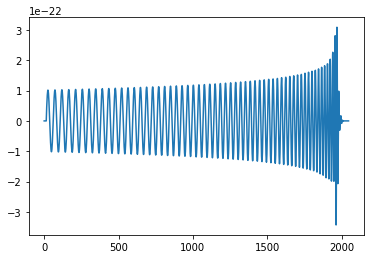

In [ ]:
plt.plot(dataset[-10]['waveform'])

In [ ]:
def show_sample(grid_size, dataset):
    rnd_inds = np.random.randint(0, len(dataset), grid_size)

    x_grid = [torch.from_numpy(dataset[i]['waveform'].reshape(1,-1)).float() for i in rnd_inds]

    x_grid = make_grid(x_grid, nrow=grid_size, padding=2)
    fig, axs = plt.subplots(nrows=1, ncols=grid_size, figsize=(22,5), sharey=True)
    for i, ax in enumerate(axs):
        ax.plot(x_grid[i].view(x_grid.shape[-1]))

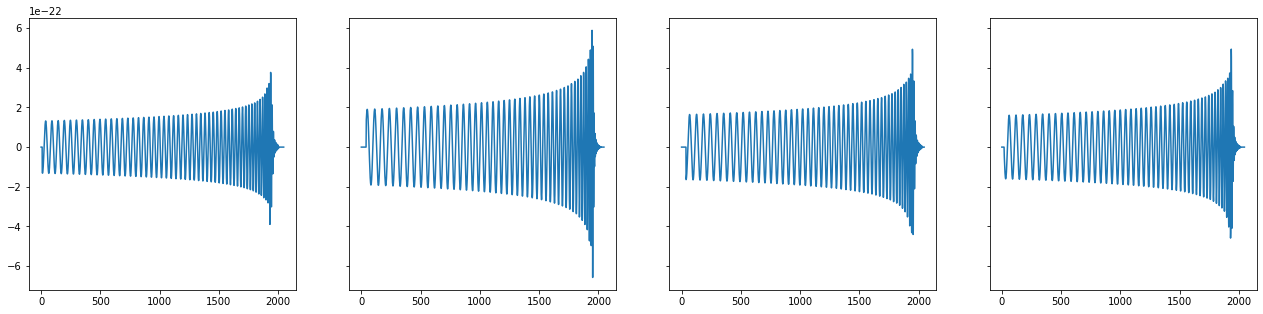

In [ ]:
show_sample(4, dataset)

In [ ]:
trn_loader = DataLoader(train_ds, batch_size=128,  collate_fn=my_collate, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)
val_loader = DataLoader(val_ds, batch_size=16, collate_fn=my_collate,shuffle=False, num_workers=4, pin_memory=True)

In [ ]:
ob = next(iter(trn_loader))

In [ ]:
ob['waveform'].shape

torch.Size([128, 1, 2048])

# The model

Now we have our dataset ready, we can start to prepare our Generator and discriminator. For that we are going to use the [WaveGan](https://arxiv.org/pdf/1802.04208.pdf) archtecture with some tricks we learned in previous lectures

## INTRINSIC DIFFERENCES BETWEEN AUDIO AND IMAGES

One way to illustrate the differences between audio and images is by examining the axes along which these types of data vary most substantially, i.e. by principal component analysis.

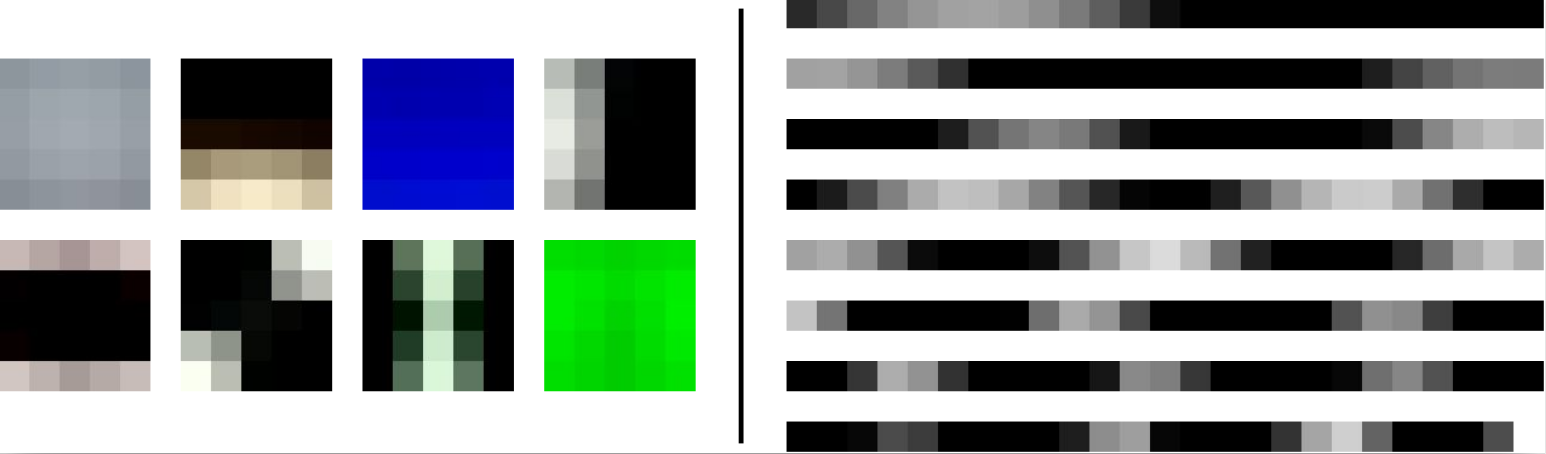
*First eight principal components for $5\times 5$ patches from natural images (**left**) versus those of length-25 audio slices from speech (**right**). Periodic patterns are unusual in natural images but a fundamental structure in audio.*

While the principal components of images generally capture intensity, gradient, and edge characteristics, those from audio form a periodic basis that decompose the audio into constituent frequency bands. In general, natural audio signals are more likely to exhibit periodicity than natural images.

As a consequence, correlations across large windows are commonplace in audio. For example, in a waveform sampled at 16 kHz, a 440 Hz sinusoid (the musical note A4) takes over 36 samples to complete a single cycle. This suggests that filters with larger receptive fields are needed to process raw audio. This same intuition motivated van den Oord et al. (2016) in their design of WaveNet, which uses dilated convolutions to exponentially increase the model’s effective receptive field with linear increase in layer depth.

# The WaveGan architecture

The WaveGAN architecture is based off of the [DCGAN](https://arxiv.org/abs/1511.06434) which popularized usage of GANs for image synthesis. The DCGAN generator uses the transposed convolution operation to iteratively upsample low-resolution feature maps into a high-resolution image.

The key difference the WaveGan has is the modification of the transposed convolution operation to widen its receptive field. Specifically, we use longer one-dimensional filters of length 25 instead of two-dimensional filters of size 5x5, and we upsample by a factor of 4 instead of 2 at each layer

The original WaveGan outputs a vector with 16384 samples, slightly more than one second of audio at 16 kHz. We reduce two layers to have the same sample rate as our waveforms. In summary we have the following modifications from the original DCGAN:

1. Flatten 2D convolutions into 1D (e.g. 5x5 2D convolution becomes length-25 1D).
2. Increase the stride factor for all convolutions (e.g. stride 2x2 becomes stride 4).
3. Remove batch normalization from the generator and discriminator.
4. Train using the WGAN-GP (Gulrajani et al., 2017) strategy

## PHASE SHUFFLE

Generative image models that upsample by transposed convolution (such as DCGAN) are known to produce characteristic ["checkerboard"](https://distill.pub/2016/deconv-checkerboard/) artifacts in images. Periodic patterns are less common in images (Section 3.1), and thus the discriminator can learn to reject images that contain them.

For the case of audio signal, the original data used in the WaveGan, analogous artifacts are perceived as pitched noise which may overlap with frequencies commonplace in the real data, making the discriminator’s objective more challenging. However, the artifact frequencies will always occur at a particular phase, allowing the discriminator to learn a trivial policy to reject generated examples. This may inhibit the overall optimization problem.

To prevent the discriminator from learning such a solution, the authors propose the *phase shuffle* operation with hyperparameter *n*. Phase shuffle randomly perturbs the phase of each layer’s activations by $-n$ to $n$ samples before input to the next layer.

The Phase shuffle operation is applied only on the discriminator, as the latent vector already provides the generator a mechanism to manipulate the phase of a resultant waveform. Intuitively speaking, phase shuffle makes the discriminator’s job more challenging by requiring invariance to the phase of the input waveform.

In [ ]:
from torch.autograd import grad, Variable

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Starting with the transposed 1D layer

In [ ]:
class Transpose1dLayer(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        stride,
        padding=11,
        upsample=None,
        output_padding=1,
        use_batch_norm=False,
    ):
        super(Transpose1dLayer, self).__init__()
        self.upsample = upsample
        reflection_pad = nn.ConstantPad1d(kernel_size // 2, value=0)
        conv1d = nn.Conv1d(in_channels, out_channels, kernel_size, stride)
        conv1d.weight.data.normal_(0., 0.02)
        conv1dTrans = nn.ConvTranspose1d(
            in_channels, out_channels, kernel_size, stride, padding, output_padding
        )
        batach_norm = nn.BatchNorm1d(out_channels)
        if self.upsample:
            operation_list = [reflection_pad, conv1d]
        else:
            operation_list = [ConvTranspose1d]
        
        if use_batch_norm:
            operation_list.append(batach_norm)
            
        self.transpose_ops = nn.Sequential(*operation_list)
        
    def forward(self, x):
        if self.upsample:
            x = nn.functional.interpolate(x, scale_factor=self.upsample, mode='nearest')
        return self.transpose_ops(x)

In [ ]:
class PhaseShuffle(nn.Module):
    """
    Performs phase shuffling, i.e. shifting feature axis of a 3D tensor
    by a random integer in {-n, n} and performing reflection padding where
    necessary.
    """

    # Copied from https://github.com/jtcramer/wavegan/blob/master/wavegan.py#L8
    def __init__(self, shift_factor):
        super(PhaseShuffle, self).__init__()
        self.shift_factor = shift_factor

    def forward(self, x):
        if self.shift_factor == 0:
            return x
        # uniform in (L, R)
        k_list = (
            torch.Tensor(x.shape[0]).random_(0, 2 * self.shift_factor + 1)
            - self.shift_factor
        )
        k_list = k_list.numpy().astype(int)

        # Combine sample indices into lists so that less shuffle operations
        # need to be performed
        k_map = {}
        for idx, k in enumerate(k_list):
            k = int(k)
            if k not in k_map:
                k_map[k] = []
            k_map[k].append(idx)

        # Make a copy of x for our output
        x_shuffle = x.clone()

        # Apply shuffle to each sample
        for k, idxs in k_map.items():
            if k > 0:
                x_shuffle[idxs] = F.pad(x[idxs][..., :-k], (k, 0), mode="reflect")
            else:
                x_shuffle[idxs] = F.pad(x[idxs][..., -k:], (0, -k), mode="reflect")

        assert x_shuffle.shape == x.shape, "{}, {}".format(x_shuffle.shape, x.shape)
        return x_shuffle

# Now we move to the Conv1D module:

In [ ]:
class Conv1D(nn.Module):
    def __init__(
        self,
        input_channels,
        output_channels,
        kernel_size,
        alpha=0.2,
        shift_factor=2,
        stride=4,
        padding=11,
        use_batch_norm=False,
        drop_prob=0
    ):
        super(Conv1D, self).__init__()
        self.conv1d = nn.Conv1d(
            input_channels, output_channels, kernel_size, stride=stride, padding=padding
        )
        self.batch_norm = nn.BatchNorm1d(output_channels)
        self.phase_shuffle = PhaseShuffle(shift_factor)
        self.alpha = alpha
        self.use_batch_norm = use_batch_norm
        self.use_phase_shuffle = shift_factor == 0
        self.use_drop = drop_prob > 0
        self.dropout = nn.Dropout2d(drop_prob)
        
    def forward(self, x):
        x = self.conv1d(x)
        if self.use_batch_norm:
            x = self.batch_norm(x)
        x = F.leaky_relu(x, negative_slope=self.alpha)
        if self.use_phase_shuffle:
            x = self.phase_shuffle(x)
        if self.use_drop:
            x = self.dropout(x)
        return x

# Building the Generator

In [ ]:
class my_WaveGanGen(nn.Module):
    
    def __init__(self,
                model_size=64,
                noise_latent_dim = 100,
                ngpus=1,
                num_channels=1,
                verbose=False,
                upsample=True,
                slice_len=2048,
                use_batch_norm=False,
                ):
        super(my_WaveGanGen, self).__init__()
            
        self.ngpus = ngpus
        self.model_size = model_size  # d
        self.num_channels = num_channels  # c
        self.latent_dim = noise_latent_dim
        self.verbose = verbose
        self.use_batch_norm = use_batch_norm
        self.dim_mul = 2
        
        self.fc1 = nn.Linear(self.latent_dim, 4 * 4 * model_size * self.dim_mul)
        self.bn1 = nn.BatchNorm1d(num_features=model_size * self.dim_mul)

        stride = 4
        if upsample:
            stride = 1
            upsample = 4
            
        deconv_layers = [
            Transpose1dLayer(
                self.dim_mul * model_size,
                (self.dim_mul * model_size) // 2,
                25,
                stride,
                upsample=upsample,
                use_batch_norm=use_batch_norm,
            ),
            Transpose1dLayer(
                (self.dim_mul * model_size) // 2,
                (self.dim_mul * model_size) // 4,
                25,
                stride,
                upsample=upsample,
                use_batch_norm=use_batch_norm,
            ),
            Transpose1dLayer(
                (self.dim_mul * model_size) // 4,
                (self.dim_mul * model_size) // 8,
                25,
                stride,
                upsample=upsample,
                use_batch_norm=use_batch_norm,
            ),
            Transpose1dLayer(
                (self.dim_mul * model_size) // 8,
                (self.dim_mul * model_size) // 16,
                25,
                stride,
                upsample=upsample,
                use_batch_norm=use_batch_norm,
            ),
        ]
        
        deconv_layers.append(
                Transpose1dLayer(
                    (self.dim_mul * model_size) // 16,
                    num_channels,
                    25,
                    1,
                    upsample=0.5
                )
            )
        self.deconv_list = nn.ModuleList(deconv_layers)
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose1d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight.data)
                
                
    def forward(self, x):
        x = self.fc1(x).view(-1, self.dim_mul * self.model_size, 16)
        if self.use_batch_norm:
            x = self.bn1(x)
        x = F.relu(x)
        if self.verbose:
            print(x.shape)

        for deconv in self.deconv_list[:-1]:
            x = F.relu(deconv(x))
            if self.verbose:
                print(x.shape)
        output = torch.tanh(self.deconv_list[-1](x))
        return output

## And the discriminator

In [ ]:
class my_WaveGANDiscriminator(nn.Module):
    def __init__(
        self,
        model_size=64,
        ngpus=1,
        num_channels=1,
        shift_factor=2,
        alpha=0.2,
        verbose=False,
        slice_len=2048,
        use_batch_norm=False,
    ):
        super(my_WaveGANDiscriminator, self).__init__()

        self.model_size = model_size  # d
        self.ngpus = ngpus
        self.use_batch_norm = use_batch_norm
        self.num_channels = num_channels  # c
        self.shift_factor = shift_factor  # n
        self.alpha = alpha
        self.verbose = verbose

        conv_layers = [
            Conv1D(
                num_channels,
                model_size,
                25,
                stride=4,
                padding=11,
                use_batch_norm=use_batch_norm,
                alpha=alpha,
                shift_factor=shift_factor,
            ),
            Conv1D(
                model_size,
                2 * model_size,
                25,
                stride=4,
                padding=11,
                use_batch_norm=use_batch_norm,
                alpha=alpha,
                shift_factor=shift_factor,
            ),
            Conv1D(
                2 * model_size,
                4 * model_size,
                25,
                stride=4,
                padding=11,
                use_batch_norm=use_batch_norm,
                alpha=alpha,
                shift_factor=shift_factor,
            ),
            Conv1D(
                4 * model_size,
                8 * model_size,
                25,
                stride=4,
                padding=11,
                use_batch_norm=use_batch_norm,
                alpha=alpha,
                shift_factor=shift_factor,
            ),
            Conv1D(
                8 * model_size,
                16 * model_size,
                25,
                stride=4,
                padding=11,
                use_batch_norm=use_batch_norm,
                alpha=alpha,
                shift_factor=shift_factor,
            ),
        ]
        self.fc_input_size = 32 * model_size
        conv_layers.append(
            Conv1D(
                16 * model_size,
                32 * model_size,
                23,
                stride=2,
                padding=11,
                use_batch_norm=use_batch_norm,
                alpha=alpha,
                shift_factor=0,
            )
        )

        self.conv_layers = nn.ModuleList(conv_layers)

        self.fc1 = nn.Linear(self.fc_input_size, 1)

        for m in self.modules():
            if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight.data)

    def forward(self, x):
        for conv in self.conv_layers:
            x = conv(x)
            if self.verbose:
                print(x.shape)
        x = x.view(-1, self.fc_input_size)
        if self.verbose:
            print(x.shape)

        return self.fc1(x)

In [ ]:
def apply_zero_grad(generator,optimizer_g,discriminator,optimizer_d):
    generator.zero_grad()
    optimizer_g.zero_grad()

    discriminator.zero_grad()
    optimizer_d.zero_grad()

In [ ]:
def sample_noise(size,noise_latent_dim):
    z = torch.FloatTensor(size, noise_latent_dim).to('cuda')
    z.data.normal_()  # generating latent space based on normal distribution
    return z

In [ ]:
def update_optimizer_lr(optimizer, lr, decay):
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr * decay
def gradients_status(model, flag):
    for p in model.parameters():
        p.requires_grad = flag

In [ ]:
def enable_disc_disable_gen(discriminator,generator):
        gradients_status(discriminator, True)
        gradients_status(generator, False)

def enable_gen_disable_disc(discriminator,generator):
    gradients_status(discriminator, False)
    gradients_status(generator, True)

def disable_all(discriminator,generator):
    gradients_status(discriminator, False)
    gradients_status(generator, False)

# Understanding the Wasserstein distance

GANs have been known to be hard to train, especially if you have tried to build one from scratch. The Wasserstein GAN (WGAN) was proposed by Martin Arjovsky, Soumith Chintala, and Léon Bottou in their paper, [*Wasserstein GAN*](https://arxiv.org/abs/1701.07875). Martin Arjovsky and Léon Bottou also laid the groundwork in an earlier paper, [*Towards Principled Methods for Training Generative Adversarial Networks*](https://arxiv.org/abs/1701.04862).

## Analyzing the problems with vanilla GAN loss:

Let's go over the commonly used loss functions for GANs:

$$\mathbb{E}_{real}[\log D(x)] + \mathbb{E}_{fake}[\log(1 - D(x))]$$

which is the vanilla form of GAN loss

$$\mathbb{E}_{fake}[\log(1 - D(x))]$$

$$\mathbb{E}_{fake}[-\log(D(x))]$$

The experimental shown that these loss functions work well in several applications. However, let's dig deep into these functions and see what could go wrong when they don't work so well:

## Step 1: Problems with the first loss function:

Assume that the generator network is trained and we need to find an optimal discriminator network D. We have the following:

$$P_r(x)\log D(x) + P_f(x)log(1-D(x))$$

Where, $P_r(x)$ represents the distribution of real data and $P_f(x)$ represents the distribution of fake (generated) data. $x$ is the real data when calculating $\mathbb{E}_{real}$ and the fake data when calculating $\mathbb{E}_{fake}$

To find the minimum of the formula, we let its derivatives regarding $D$ to be zero and get the following:

$$D^{\prime}(x) = \frac{P_r(x)}{P_r(x) + P_f(x)}$$

Therefore, the first loss function becomes (when D is optimal) as follows:

$$\mathbb{E}_{real}[\frac{P_r(x)}{\frac{1}{2}(P_r(x) + P_f(x))}] + \mathbb{E}_{fake}[\frac{P_r(x)}{\frac{1}{2}(P_r(x) + P_f(x))}] - 2\log 2$$
 
$$ = 2\mathrm{JS}(P_r\vert\vert P_f) - 2\log 2$$

is the [Jensen-Shannon divergence](https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence) (JS divergence), which is the symmetric version of the [Kullback-Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) (KL divergence):

$$KL(P_r\vert\vert P_f) = \mathbb{E}_{P_r}[\log\frac{P_r}{P_f}]$$ 

$$JS(P_r\vert\vert P_f) = \frac{1}{2} KL(P_r \vert\vert \frac{P_r + P_f}{2}) + \frac{1}{2} KL(P_f \vert\vert \frac{P_r + P_f}{2})$$

The Kullback-Leibler divergence is usually used to describe the distance between two distributions. It equals the cross entropy of $P_r$ and $P_f$ minus the entropy of $P_r$, which is why KL divergence is also called relative entropy.

Keep in mind that KL divergence is not symmetric, for $P_r = 0$ and $P_f = 1$ we have $KL(P_r\vert\vert P_f) = 0$, while for the case of $P_r = 1$ and $P_f = 0$ the becomes $KL(P_r\vert\vert P_f) = \infty$

!! **A problem with *JS* divergence is that when $P_r$ and $P_f$ are apart from each other (with no or little overlapping part), its value remains $-2\log 2$ no matter how far away $P_r$ and $P_f$ are from each other. It's rather reasonable to assume that $P_r$ and $P_f$ are no way near each other at the beginning of training (since the generator is randomly initialized and could be anywhere in the data space). A nearly constant loss is hardly giving useful information to the derivatives when the discriminator is optimal. Therefore, when using the first form of loss in GANs, a well-trained discriminator will stop the generator from improving itself** !!

## Step 2: The problems with the other two loss functions:

Let's take the third loss for example. It can be written as follows:

$$KL(P_r\vert\vert P_f) - \mathbb{E}_{P_f}[\log (1-D^{\prime})]$$ 
$$ = KL(P_r\vert\vert P_f) - 2 JS(P_r \vert\vert P_f) + 2\log 2 + \mathbb{E}_{P_r}[\log (D^{\prime})]$$

The last two terms are irrelevant to the generator. The first two terms are, however, aiming for totally opposite objectives (minimizing the KL divergence while maximizing the JS divergence). This causes the training to be very unstable. On the other hand, the employment of KL divergence can lead to **mode collapse**. Failing to generate realistic samples is severely penalized ($KL(P_r\vert\vert P_f) = \infty$ when $P_f > 0$ and $P_r = 0$) but generating only a few kinds of realistic samples is not penalized ($KL(P_r\vert\vert P_f) = 0$ when $P_f = 0$ and $P_r > 0$). This makes the generator more prone to generate samples with less variety.

# The advantages of Wasserstein distance

Wasserstein distance (also called Earth Mover's Distance or EMD) is defined as follows:

$$ W(P_r, P_f) = \text{inf}_{\gamma \sim \pi} \mathbb{E}_{(x,y)\sim\gamma}[\vert\vert x - y \vert\vert]$$

$$ = \frac{1}{K}\text{sup}_{\vert\vert f\vert\vert_L \leq K} \mathbb{E}_{P_r}[f] - \mathbb{E}_{P_f}[f]$$

It essentially describes the least distance between two variables sampled from all possible joint distributions. In plain words, it is the minimum cost of moving one pile of dirt (in a shape of certain distribution) to form a different pile (another distribution).

Compared to JS divergence, the Wasserstein distance can properly describe the distance between real data and fake data even when they are far apart from each other. Therefore, the derivatives can be correctly calculated to update the generator network when the discriminator is good.

To find the most suitable function, f, we can simply train a neural network to estimate it (luckily, we are already training a discriminator network). An important condition for the second line of the equation to hold is that all functions, f, are [Lipschitz continuous](https://en.wikipedia.org/wiki/Lipschitz_continuity):

$$\vert f(x_1) - f(x_2)\vert \leq K\vert x_1 - x_2\vert , K \geq 0 $$

for any $x_1 , x_2$. Lipschitz continuity is easy to achieve in neural networks by clipping any gradient value that's larger than K to be K ([gradient clipping](https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html)), or simply clipping the weight values to a constant value ([weight clipping](https://pytorch.org/docs/stable/generated/torch.clamp.html)).

Finally, the Wasserstein loss is written as follows:

$$\text{G-loss:} -\mathbb{E}_{fake}[D(x)]$$

$$\text{D-loss:} \mathbb{E}_{fake}[D(x)] - \mathbb{E}_{real}[D(x)]$$

However, there are also some issues with gradient clipping when training a very deep neural network. First, if the gradients/weights are clamped to $[-c, c]$ too often, they tend to stick with $-c$ or $c$ by the end of training while only a few parameters have values between the two ends. Second, clamping the gradients to a larger or smaller range could cause "invisible" gradient vanishing or explosion.

We call it "invisible" because even though the gradient values are extremely large, they are eventually clamped to [-c, c]. But it will be a complete waste of computational resources. Therefore, Ishaan Gulrajani, Faruk Ahmed, Martin Arjovsky, et. al. proposed to add a penalty term to the discriminator loss, namely, gradient penalty, in their paper, *Improved Training of Wasserstein GANs*:

$$\mathbb{E}_{fake}[D(\hat{x})] - \mathbb{E}_{real}[D(x)] + \lambda \mathbb{E}_{\hat{x}}[\vert\vert \frac{\partial D(\hat{x})}{\partial \hat{x}}\vert\vert_2 - 1]^2$$

$$ \hat{x} = \alpha x_{real} + (1 - \alpha) x_{fake}\ , \ \alpha \sim \mathbb{U}(0, 1)$$

The penalty gradient is calculated with regards to a random interpolation between a pair of real data and fake data.

In a nutshell, to use Wasserstein loss, you'll need to do the following:

- Get rid of the Sigmoid function at the last layer of the discriminator network.
- Don't apply the log function to the results when calculating the loss.
- Use the gradient penalty (or simply clip the weights in shallow neural networks).
- Use RMSprop instead of Momentum or Adam to train your networks.

In [ ]:
def calculate_discriminator_loss(real, generated, batch_size, discriminator):

    disc_out_gen = discriminator(generated)
    disc_out_real = discriminator(real)
    alpha = torch.FloatTensor(batch_size, 1, 1).uniform_(0, 1).to('cuda')
    alpha = alpha.expand(batch_size, real.size(1), real.size(2))

    #gradient penalty !!!!
    interpolated = (1 - alpha) * real.data + (alpha) * generated.data[:batch_size]
    interpolated = Variable(interpolated, requires_grad=True)

    # calculate probability of interpolated examples
    prob_interpolated = discriminator(interpolated)
    grad_inputs = interpolated
    ones = torch.ones(prob_interpolated.size()).to('cuda')
    gradients = grad(
        outputs=prob_interpolated,
        inputs=grad_inputs,
        grad_outputs=ones,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    # calculate gradient penalty
    grad_penalty = (
        10
        * ((gradients.view(gradients.size(0), -1).norm(2, dim=1) - 1) ** 2).mean()
    )
    assert not (torch.isnan(grad_penalty))
    assert not (torch.isnan(disc_out_gen.mean()))
    assert not (torch.isnan(disc_out_real.mean()))
    cost_wd = disc_out_gen.mean() - disc_out_real.mean()
    cost = cost_wd + grad_penalty
    return cost, cost_wd

In [ ]:
def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

In [ ]:
def show_batch(real_samples, generator, latent_dim, batch_size, grid_size, epoch_info, path_to_save):
    z = Variable(torch.randn(batch_size, latent_dim, dtype=torch.float, device='cuda'))
    real_ts = real_samples
    with torch.no_grad():
        gen_waves = generator(z)
    gen_waves = gen_waves.to('cpu')
    x_grid = make_grid(gen_waves, nrow=grid_size, padding=2)
    x_grid_real = make_grid(real_ts, nrow=grid_size, padding=2)    
    cols = grid_size
    rows = batch_size // cols + 1
    fig, axs = plt.subplots(rows, cols, figsize=(22,12), constrained_layout=True)
    axs = trim_axs(axs, batch_size)
    for i, ax in enumerate(axs):
        ax.plot(x_grid[i].view(x_grid.shape[-1]).detach().numpy(), label='fake')
        ax.plot(x_grid_real[i].view(x_grid_real.shape[-1]).cpu().detach().numpy(), alpha=0.5, label='real')        
        ax.set_xticks([])
    fig.suptitle(f'Epoch: {epoch_info[0]}', fontsize=18)
    plt.savefig(path_to_save.joinpath(f'sample_waves_{epoch_info[0]}.png'), bbox_inches='tight')
    plt.show()

In [ ]:
G = my_WaveGanGen()
D = my_WaveGANDiscriminator()

In [ ]:
G.to('cuda');
D.to('cuda');

In [ ]:
def train(params):
    generator = params['generator']
    optimizer_g = params['optimizer_g']
    descriminator = params['descriminator']
    optimizer_d = params['optimizer_d']
    data_loader = params['data_loader']
    num_epochs = params['num_epochs'] 
    check_every = params['check_every']
    decay_lr = params['decay_lr']
    path_generator = params['path_generator']
    path_descriminator = params['path_descriminator']
    path_plots = params['path_plots']
    
    path_generator.mkdir(parents=True, exist_ok=True)
    path_descriminator.mkdir(parents=True, exist_ok=True)
    path_plots.mkdir(parents=True, exist_ok=True)
    
    generator.train()
    descriminator.train()
    loss_desc = {
        'train':[]
    }
    loss_gen = {
        'train':[]
    }
    
    for epoch in range(num_epochs):
        running_loss_desc = 0.0
        running_loss_gen = 0.0
        len_data = len(data_loader.dataset)
        for i, data in enumerate(data_loader):
            batch_size = data['waveform'].shape[0]
            enable_disc_disable_gen(descriminator,generator)
            real_signal = data['waveform'].to('cuda')
            noise = sample_noise(batch_size, 100)
            apply_zero_grad(generator, optimizer_g, descriminator, optimizer_d)
            valid = Variable(torch.FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
            fake = Variable(torch.FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)
            generated = generator(noise)
            disc_cost, disc_wd = calculate_discriminator_loss(
                real_signal, generated, 
                batch_size, descriminator
                )
            assert not (torch.isnan(disc_cost))
            running_loss_desc += disc_cost.item()
            disc_cost.backward()
            optimizer_d.step()
            
            apply_zero_grad(generator, optimizer_g, descriminator, optimizer_d)
            enable_gen_disable_disc(descriminator, generator)
            noise = sample_noise(batch_size, 100)
            generated = generator(noise)
            discriminator_output_fake = descriminator(generated)
            generator_cost = -discriminator_output_fake.mean()
            running_loss_gen += generator_cost.item()
            generator_cost.backward()
            optimizer_g.step()
            disable_all(descriminator,generator)
            
            # lr decay
            if decay_lr:
                decay = max(0.0, 1.0 - (epoch * 1.0 / num_epochs))
                # update the learning rate
                update_optimizer_lr(optimizer_d, lr_d, decay)
                update_optimizer_lr(optimizer_g, lr_g, decay)
            
        print(f'Epoch {epoch} -> loss_D_real: {running_loss_desc/float(len_data):.4f}, loss_G: {running_loss_gen/float(len_data):.4f}', end='\r')
        
        loss_desc['train'].append(running_loss_desc/float(len_data))
        loss_gen['train'].append(running_loss_gen/float(len_data))        
        if epoch % check_every == 0:
            
            torch.save(generator.state_dict(), path_generator.joinpath(f'generator_{epoch}.pth'))            
            torch.save(descriminator.state_dict(), path_descriminator.joinpath(f'descriminator_{epoch}.pth'))            
            generator.eval()
            with torch.no_grad():
                print(real_signal.shape)
                bv = next(iter(val_loader))
                show_batch(bv['waveform'].to('cuda'), generator,100,16,4,[epoch], path_plots)
            
    generator.eval()
    return descriminator, generator, loss_desc, loss_gen

In [ ]:
lr_g = 1e-4
lr_d = 3e-4 
beta1 = 0.5
beta2 = 0.9

optimizer_g = optim.Adam(G.parameters(), lr=lr_g, betas=(beta1, beta2)) 
optimizer_d = optim.Adam(D.parameters(), lr=lr_d, betas=(beta1, beta2))

In [ ]:
parms_train = {
    'generator':G,
    'optimizer_g':optimizer_g,
    'descriminator':D,
    'optimizer_d':optimizer_d,
    'data_loader':trn_loader,
    'num_epochs':501, 
    'check_every':250,
    'decay_lr':False,
    'path_generator':OUT_PATH/'models/generators',
    'path_descriminator':OUT_PATH/'models/discriminators/',
    'path_plots':Path('./plots/')
}

torch.Size([128, 1, 2048]).0792, loss_G: -0.0230


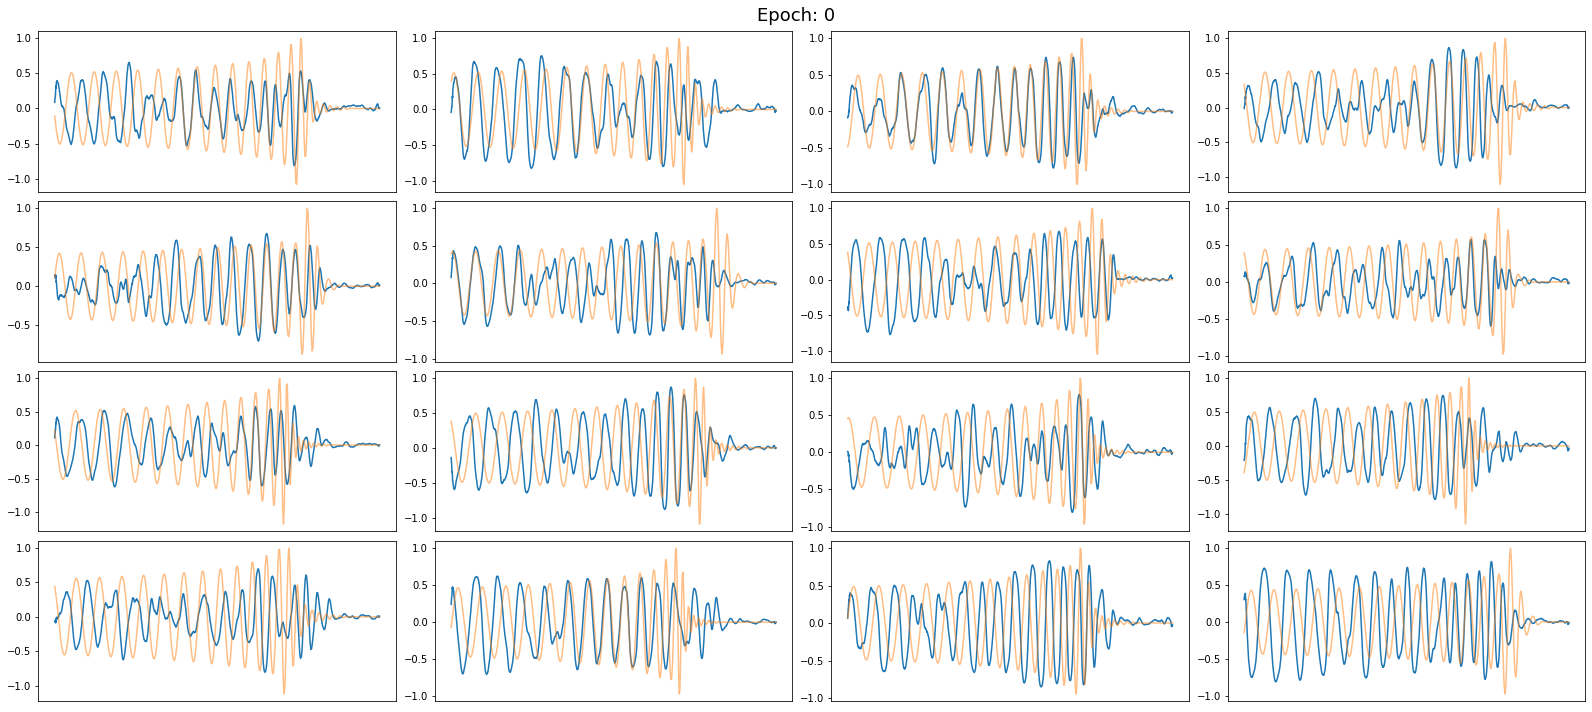

torch.Size([128, 1, 2048])-0.0605, loss_G: 0.00791


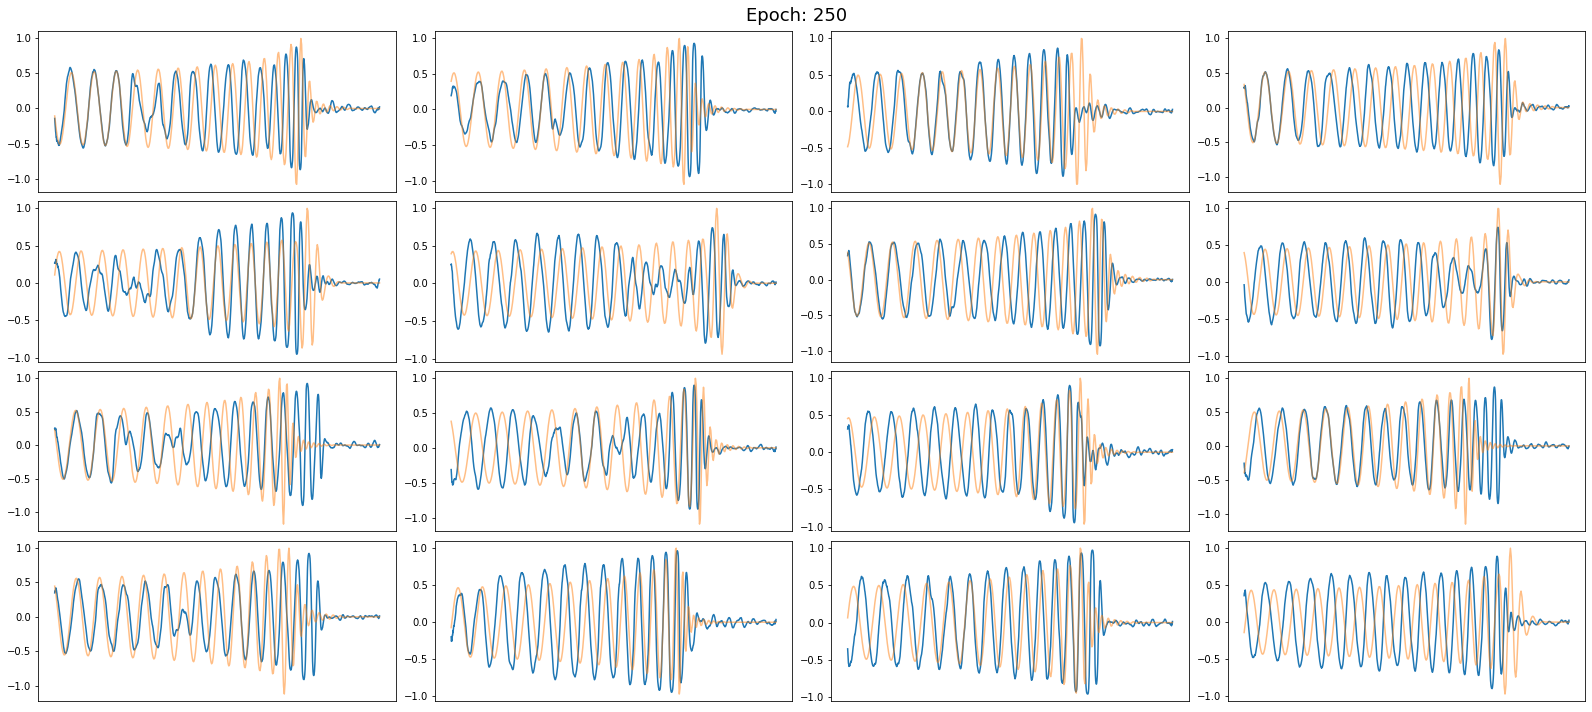

torch.Size([128, 1, 2048])-0.0474, loss_G: 0.0060


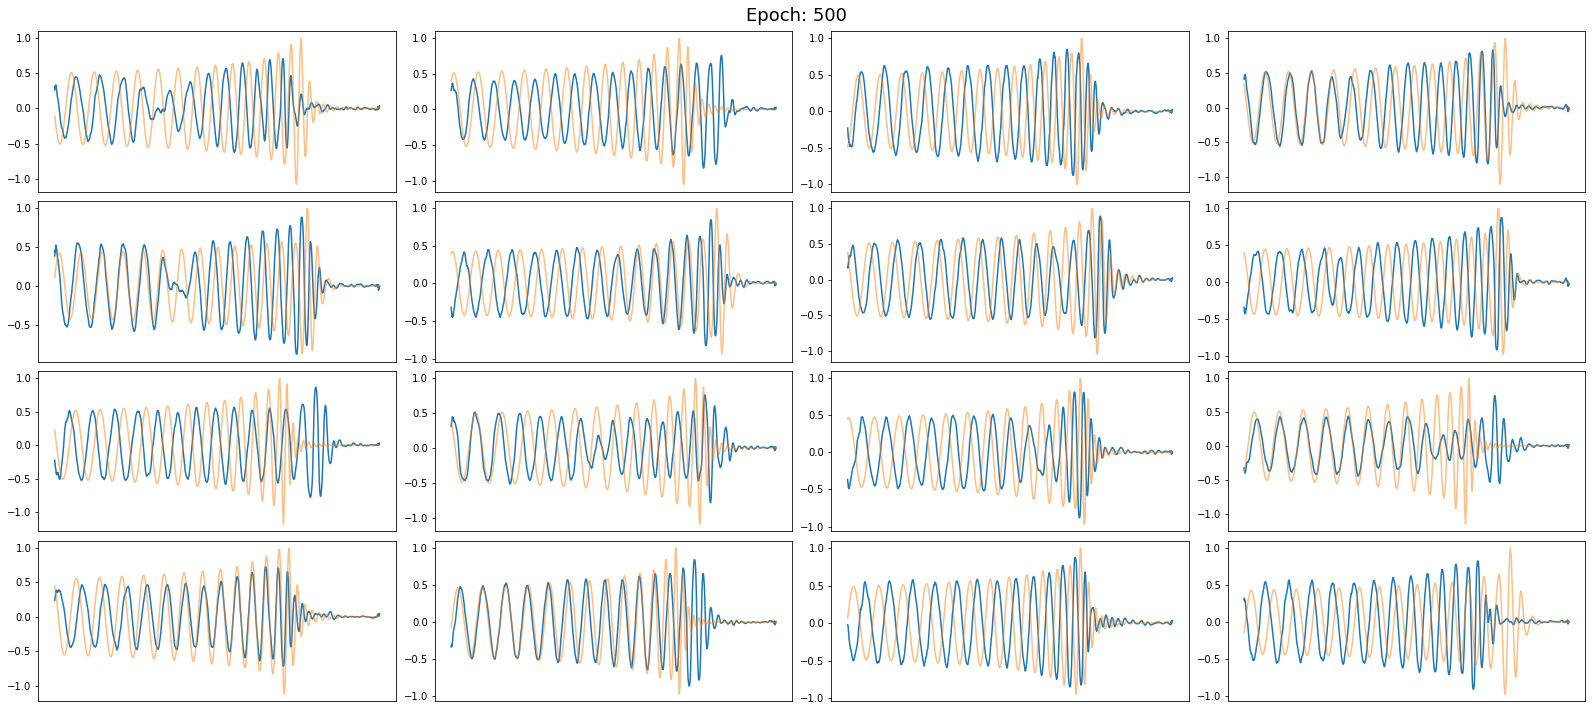

In [ ]:
DT, GT, ld, lg = train(parms_train)

![Alt Text](https://media.giphy.com/media/vFKqnCdLPNOKc/giphy.gif)

In [ ]:
#torch.save(GT.state_dict(), f'models/generators/generator_Final.pth')

In [ ]:
#G.load_state_dict(torch.load(models/generators/generator_Final.pth))
#G.to('cuda')

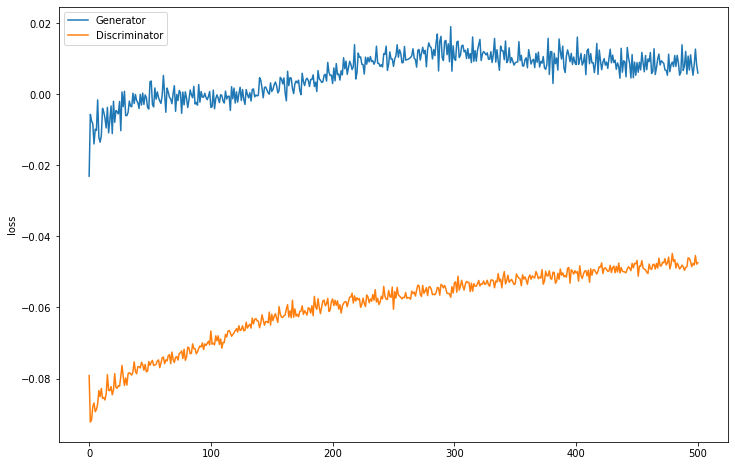

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(lg['train'], label='Generator')
plt.plot(ld['train'], label='Discriminator')
plt.ylabel('loss')
plt.legend(loc='best');

# Generate some samples:

In [ ]:
def gen_synth(generator, num_samples):
    z = sample_noise(num_samples, 100)
    with torch.no_grad():
        gen = generator(z)
    gen = torch.flatten(gen, 1).cpu().numpy()
    return gen

In [ ]:
ss = gen_synth(GT, 1000)

In [ ]:
ss.shape

(1000, 2048)

[<matplotlib.lines.Line2D>]

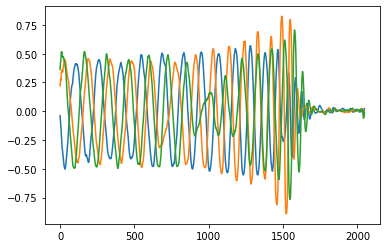

In [ ]:
plt.plot(ss[10])
plt.plot(ss[50])
plt.plot(ss[150])